In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy.stats as stats
import sympy
import matplotlib.pyplot as plt


def monte_carlo(num_samples, sample_generator, g_evaluator, cumsum=False):
    """Perform Monte Carlo sampling
    
    Inputs
    ------
    num_samples: integer, number of samples
    sample_generator: A function that generates samples with signature sample_generator(nsamples)
    g_evaluator: a function that takes as inputs the samples and outputs the evaluations. 
                 The outputs can be any dimension, however the first dimension should have size *num_samples*
    cumsum: Boolean, an option to return estimators of all sample sizes up to num_samples
                 
    Returns
    -------
    A Monte Carlo estimator of the mean, samples, and evaluations
    """
    samples = sample_generator(num_samples)
    evaluations = g_evaluator(samples)
    if cumsum is False:
        estimate =  np.sum(evaluations, axis=0) / float(num_samples)
    else:        
        estimate = np.cumsum(evaluations, axis=0) / np.arange(1,num_samples+1, dtype=np.float)
        
    return estimate, samples, evaluations

# Multilevel Monte Carlo for stochastic differential equations: a case study for the Ornstein-Uhlenbeck process
Alex Gorodetsky, 2020, 2021

Multilevel Monte Carlo is extremely useful in cases where one is simulating stochastic dynamics. $$dX_t = b(t, X)dt + h(t, X) dW_t$$

This equation denotes that the "mean-trend" of the change in $X$ with time is given by $b$, typically called the *drift*, but that it is disturbed by some noise that is distributed like a Gaussian. $h$ is a function called the *diffusion* and scales the random forcing. In this case, $W_t$ is called *Brownian Motion* (or a Wiener process) and has the following properties

A Brownian motion is a stochastic process in time, denoted by $W_t$, with the properties
0. *initial condition:* $W_0 = 0$ a.s
1. *normally distributed:* $W_t \sim \mathcal{N}(0, t)$ 
2. *covariance structure:* $\mathbb{E}\left[W_t  W_s\right] = \min(s, t)$
3. *independent normal increments:* $W_{t_2} - W_{t_1}$ is distributed according to a normal $\mathcal{N}(0, t_2-t_1)$ and $W_{t_4} - W_{t_3}$ is independent of $W_{t_2} - W_{t_1}$ whenever the time increments don't intersect ($0 \leq t_1 \leq t_2 \leq t_3 \leq t_4$)
4. $W_t$ has continuous paths (as a function of $t$) with probability 1.


We will be using the simulators developed in the other notebook, in vectorized form

In [3]:
def brownian_motion_simulate(T, dt, num_paths):
    """Simulate a single path of brownian motion
    
    Inputs
    ------
    T: floating point variable, greater than 0, final time 
    dt: time increment of the simulation
    
    Returns
    -------
    bmotion: single path of a brownian motion simulation (nsamples, npaths)
    """
    nsamples = int(np.ceil(T / dt)) + 1
    samples = np.random.randn(nsamples, num_paths) * np.sqrt(dt)
    samples[0] = 0.0
    bmotion = np.cumsum(samples, axis=0)
    return bmotion

def brownian_motion_fine_to_coarse(T, dt, brownian_fine, M):
    """Extract a sample of a coarse brownian motion simulation from a fine brownian motion simulation"""
    
    nsamples = int(np.ceil(T/dt)) + 1
    npaths = brownian_fine.shape[1]
    brownian_coarse = np.zeros((nsamples, npaths))
    brownian_coarse[0, :] = brownian_fine[0, :]
    for ii in range(1, nsamples):
        delta = brownian_fine[ii * M, :] - brownian_fine[(ii-1)*M, :]
        brownian_coarse[ii, :] = brownian_coarse[ii-1, :] + delta
    return brownian_coarse


## Multilevel monte Carlo for SDEs: two levels

Lets now code up an MLMC algorithm for SDEs using two levels. We will use the Euler Maruyama discretization in time, with the coarse time discretization using time steps four times as long. We will play around with a process called the [Ornstein-Uhlenbeck process](https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process). This process comes up a lot in finance and physics --- read through the wiki page if you are interested! It takes the form

\begin{equation}
dX_t = -\theta X_t dt + \sigma dW_t
\end{equation}
where $\theta$ and $\sigma$ are fixed parameters. 

We will use a numerical scheme, called Euler-Maruyama, to simulate this stochastic differential equation. For a general SDE, reproduced below,
\begin{equation}
dX_t = b(t, X) dt + h(t, X) dW_t
\end{equation}
the scheme looks as follows
\begin{equation}
X(t_{k+1}) = X(t_{k}) + b(t_{k}, X(t_{k}))\Delta t + h(t_{k}, X(t_{k})) \left(W(t_{k+1}) - W(t_{k})\right)
\end{equation}

In [13]:
def euler_maruyama(b, h, x0, dt, T, bmotion):
    """Perform Euler Maruyama integration to integrate a one dimensional SDE
        
        dX = b(t, X) dt + h(t, X) dW
    
    Inputs
    ------
    b: function taking input of a single time and a vector of (Npaths) values X
    h: function taking input of a single time and a vector of (Npaths) values X
    x0: initial condition (Npaths, )
    dt: time step
    T: final time
    bmotion: a brownian motion simulation (Nsteps, Npaths) that is consistent with dt and T
    
    Returns
    -------
    times: time incrememnts
    paths: (Nsteps, npaths)
    """
    
    num_paths = x0.shape[0]
    assert bmotion.shape[1] >= num_paths, "Not enough brownian motions simulated"
    num_steps = int(np.ceil(T / dt)) + 1
    paths = np.zeros((num_steps, num_paths))
    paths[0, :] = x0
    times = np.zeros(num_steps)
    t = 0
    for ii in range(1, num_steps):
        paths[ii, :] = paths[ii-1, :] + b(t, paths[ii-1, :]) * dt + h(t, paths[ii-1, :]) * (bmotion[ii, :] - bmotion[ii-1, :])
        t += dt
        times[ii] = t;
    return times, paths

Define the process

In [5]:
theta = 0.5
sigma = 0.1
ou_bfunc = lambda t, x: -theta * x
ou_hfunc = lambda t, x: sigma * np.ones(x.shape)

Now lets simulate and plot

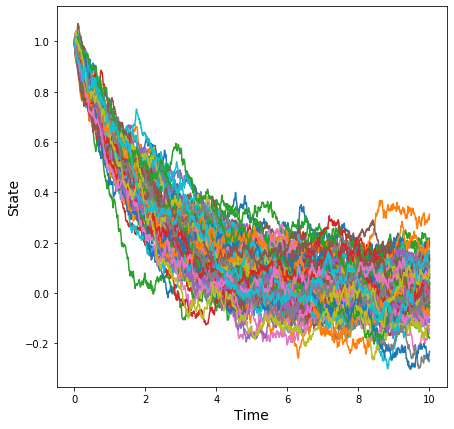

In [6]:
def sim_and_plot(num_paths=20):
    
    T = 10.0
    dt = 1e-2
    bmotion = brownian_motion_simulate(T, dt, num_paths)
    x0 = np.ones((num_paths)) # start at 1
    times, states = euler_maruyama(ou_bfunc, ou_hfunc, x0, dt, T, bmotion)
    
    plt.figure(figsize=(7, 7))
    plt.plot(times, states)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('State', fontsize=14)
    plt.show()
sim_and_plot(num_paths=100)

Interesting! This process is a mean reverting process. Over time it goes back to mean zero and standard deviation specified by $\sigma$.

Lets setup some quantity of interest that we would like to compute. For example lets try to get the expectation of the integral of this process using a simple zeroeth order quadrature rules
\begin{equation}
Y = g(W(t)) = \int_{0}^T X(t) dt \approx \sum_{i=1}^{nsteps} \Delta t X(i) 
\end{equation}
As the number of steps increases (time decreases), we will get a more accurate approximation. 

We will have two levels of approximation $Y^f$ and $Y^c$, where the fine level uses a four times finer process than the coarse level. Recall the MLMC estimate is then.

\begin{equation}
\mathbb{E}\left[ Y^f \right] = \mathbb{E}\left[ Y^c \right] + \mathbb{E}\left[Y^f - Y^c \right]
\end{equation}

The idea is that the first expectation is cheap to evaluate because it only relies on coarse grid simulations. The second expectation involves both coarse and fine grid simulations; however we hope that the variance is low so we don't need too many samples. Lets see if this is true...

In [7]:
def evaluator(bmotion, dt, T):
    """ Evaluate an approximate integral of a path of the OU process"""
    
    num_paths = bmotion.shape[1]
    x0 = np.ones((num_paths)) # start at 1
    times, states = euler_maruyama(ou_bfunc, ou_hfunc, x0, dt, T, bmotion)
    res = np.sum(states, axis=0) * dt
    res = res[:, np.newaxis] # make this an N x 1 array, which is what we need for the monte carlo function
    return res

def sampler(nsamples, dt, T):
    """ Generate samples of the brownian motion"""
    bmotion = brownian_motion_simulate(T, dt, nsamples)
    return bmotion

Lets first run monte Carlo and see what we get

Monte Carlo Estimate is [1.96183596]
Estimated Monte Carlo Standard Error is 0.016810977759282763


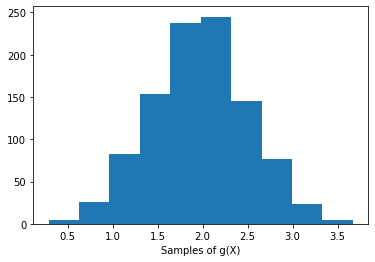

In [8]:
nsamples = 1000
dt = 1e-2
T = 10.0
g = lambda X: evaluator(X, dt, T)
s = lambda N: sampler(N, dt, T)
estimate, samples, evals = monte_carlo(nsamples, s, g)
plt.figure()
plt.hist(evals)
plt.xlabel("Samples of g(X)")
print("Monte Carlo Estimate is {0}".format(estimate))
print("Estimated Monte Carlo Standard Error is {0}".format(np.sqrt(np.var(evals))/np.sqrt(nsamples)))

Lets now write a multilevel Monte Carlo routine with two levels to try to reduce the variance

In [9]:
def multilevel_montecarlo_sde(func, nsamples_level_0, nsamples_level_1, dt_fine, T, M):
    """Multilevel Monte Carlo for Stochastic differential equations"""

    dt_coarse = dt_fine * M
    
    ###########################
    # level 0 Only coarse grid evaluations are used
    ###########################
    bmotion_level_0 = brownian_motion_simulate(T, dt_coarse, nsamples_level_0)
    samples_level_0 = func(bmotion_level_0, dt_coarse, T)
    
    #####################
    # level 1
    ######################
    # First generate fine and coarse bmotion samples
    bmotion_level_1_fine = brownian_motion_simulate(T, dt_fine, nsamples_level_1)
    bmotion_level_1_coarse = brownian_motion_fine_to_coarse(T, dt_coarse, bmotion_level_1_fine, M)
        
    # Next evaluate the samples
    samples_level_1_fine = func(bmotion_level_1_fine, dt_fine, T)
    samples_level_1_coarse = func(bmotion_level_1_coarse, dt_coarse, T)

    # Now subtract
    samples_delta_level_1 = samples_level_1_fine - samples_level_1_coarse
    
    #####################
    ## Combine levels
    #####################
    est_mean = np.mean(samples_level_0) + np.mean(samples_delta_level_1)
    est_var_levels =  (np.var(samples_level_0), np.var(samples_level_1_fine), np.var(samples_delta_level_1))

    return est_mean, est_var_levels

Lets run a quick sanity check, same as before.

In [10]:
# Do many samples for both since we want good estimates to check
nsamples_0 = 1000 # level 0 (coarse)
nsamples_1 = 1000  # level 1 (fine)
dt = 1e-2 # fine
T = 10.0
M = 4 # coarse scalae
est_mlmc, (Vcoarse, Vfine, Vdelta) = multilevel_montecarlo_sde(evaluator, nsamples_0, nsamples_1, dt, T, M)
print("Monte Carlo Estimate is {0}".format(est_mlmc))
print("Variance of coarse process = {:5f}".format(Vcoarse))
print("Variance of fine process = {:5f}".format(Vfine))
print("Variance of discrepency = {:5f}".format(Vdelta))

Monte Carlo Estimate is 1.9793003369933062
Variance of coarse process = 0.273236
Variance of fine process = 0.294866
Variance of discrepency = 0.000007


Its pretty close to before, so it seems to be working. Also, look at the variance of the discrepancy! It is so small, this means we will be able to use very few samples to estimate this level.


Lets now look at the distribution of the estimators

In [11]:
dt = 1e-2
T = 10.0
M = 4
N0 = 400 # coarse samples
N1 = 20 # fine samples
cost_mlmc = N0/M + N1/M + N1 # compute cost assuming high-fidelity is one unit
#cost_mlmc = numberofsimulations_hf * cost_hf + number_of_simulations_lf * cost_lf

equiv_mc = int(cost_mlmc) # equivalent number of monte carlo samples (to equialize cost)
ntrials = 1000
MC_est = np.zeros((ntrials))
MLMC_est = np.zeros((ntrials))

# Needed for MC for high-fidelity
g = lambda X: evaluator(X, dt, T)
s = lambda N: sampler(N, dt, T)

for ii in range(ntrials):
    MC_est[ii] = monte_carlo(equiv_mc, s, g)[0]
    MLMC_est[ii] = multilevel_montecarlo_sde(evaluator, N0, N1, dt, T, M)[0]
    if ii % 50 == 0:
        print("On Iteration {0}/{1}".format(ii+1, ntrials))

On Iteration 1/1000
On Iteration 51/1000
On Iteration 101/1000
On Iteration 151/1000
On Iteration 201/1000
On Iteration 251/1000
On Iteration 301/1000
On Iteration 351/1000
On Iteration 401/1000
On Iteration 451/1000
On Iteration 501/1000
On Iteration 551/1000
On Iteration 601/1000
On Iteration 651/1000
On Iteration 701/1000
On Iteration 751/1000
On Iteration 801/1000
On Iteration 851/1000
On Iteration 901/1000
On Iteration 951/1000


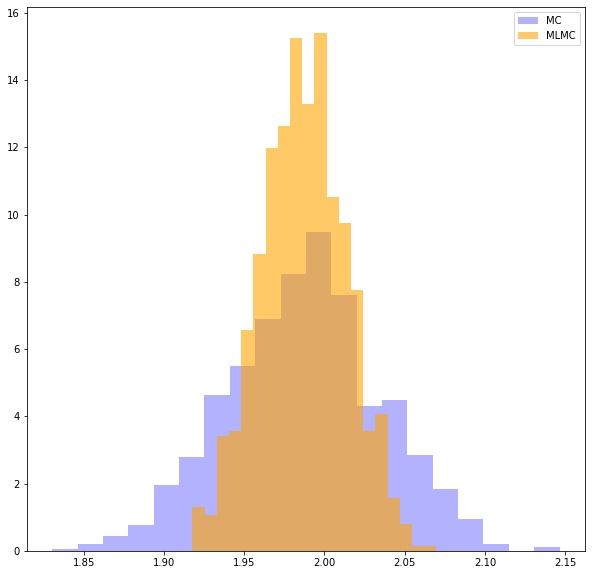

In [12]:
plt.figure(figsize=(10,10))
plt.hist(MC_est, density=True, color='blue', label='MC',alpha=0.3, bins=20)
plt.hist(MLMC_est, density=True, color='orange', label='MLMC',alpha=0.6, bins=20)
plt.legend()
plt.show()

How can we improve this further? Optimal sample allocation!